## Confronto sentiment con Tintoria podcast

Potrei prendere 200 commenti per video per un numero di video pari al numero di video che ci sono nell'ultima fase che ho identificato per Muschio selvaggio.

In [1]:
import json
import time
import os
import networkx as nx
from itertools import combinations

#build permette di definire il punto di accesso da cui invocare i diversi endpoint delle YouTube API.
from googleapiclient.discovery import build

In [2]:
API_KEY = os.environ.get("API_KEY")

In [5]:
DEVELOPER_KEY = API_KEY
YOUTUBE_API_SERVICE_NAME = 'youtube'
YOUTUBE_API_VERSION = 'v3'

In [8]:
youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION, developerKey = DEVELOPER_KEY)

In [11]:
request = youtube.search().list(
        part="snippet",
        maxResults=5,
        q="tintoria podcast",
        type="channel"
    )
response = request.execute()

response

{'kind': 'youtube#searchListResponse',
 'etag': 'hkOJUYN8EOECyVyPzsCYSqpK07s',
 'nextPageToken': 'CAUQAA',
 'regionCode': 'US',
 'pageInfo': {'totalResults': 27, 'resultsPerPage': 5},
 'items': [{'kind': 'youtube#searchResult',
   'etag': 'j6xGMifsAc9pDVj-CB3gWcQ8enY',
   'id': {'kind': 'youtube#channel', 'channelId': 'UCvbLX67F72gQBrqE4IX5yGA'},
   'snippet': {'publishedAt': '2011-11-02T22:56:11Z',
    'channelId': 'UCvbLX67F72gQBrqE4IX5yGA',
    'title': 'Tintoria Podcast',
    'description': '',
    'thumbnails': {'default': {'url': 'https://yt3.ggpht.com/sdTwi42rzLA6ysXSf0Kp5wlqNXCHwyi688OAJrRHLkZf93-OXCDsBkiMoz0JYYFKPkJChQE1GvU=s88-c-k-c0xffffffff-no-rj-mo'},
     'medium': {'url': 'https://yt3.ggpht.com/sdTwi42rzLA6ysXSf0Kp5wlqNXCHwyi688OAJrRHLkZf93-OXCDsBkiMoz0JYYFKPkJChQE1GvU=s240-c-k-c0xffffffff-no-rj-mo'},
     'high': {'url': 'https://yt3.ggpht.com/sdTwi42rzLA6ysXSf0Kp5wlqNXCHwyi688OAJrRHLkZf93-OXCDsBkiMoz0JYYFKPkJChQE1GvU=s800-c-k-c0xffffffff-no-rj-mo'}},
    'channelTitle'

In [14]:
channelId = response['items'][0]['snippet']['channelId']
channelId

'UCvbLX67F72gQBrqE4IX5yGA'

In [17]:
request = youtube.channels().list(
        part="snippet,contentDetails",
        id=channelId
    )
response = request.execute()

In [20]:
uploaded_playlist = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
uploaded_playlist

'UUvbLX67F72gQBrqE4IX5yGA'

In [23]:
#filtro via gli shorts
def get_regular_videos(video_ids):
    regular_videos = []
    for video_id in video_ids:
        request = youtube.videos().list(
            part='contentDetails',
            id=video_id
        )
        response = request.execute()

        duration = response['items'][0]['contentDetails']['duration']
        # Converti la durata ISO 8601 in secondi e filtra i video più lunghi di 60 secondi
        if isodate.parse_duration(duration).total_seconds() > 600:
            regular_videos.append(video_id)

    return regular_videos


In [ ]:
def get_latest_video_ids(playlist_id, max_results=30):
    video_ids = []
    request = youtube.playlistItems().list(
        part="snippet",
        playlistId=playlist_id,
        maxResults=max_results,
        fields="items(snippet/resourceId/videoId)"
    )
    response = request.execute()

    for item in response.get('items', []):
        video_ids.append(item['snippet']['resourceId']['videoId'])

    return video_ids



In [ ]:
def get_comments(video_id, max_comments=200):
    comments = []
    page_token = None
    total_fetched = 0  # Tieni traccia del numero totale di commenti raccolti

    while True:
        request = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=100,  # Numero massimo di commenti per richiesta (limite API)
            textFormat='plainText',
            pageToken=page_token
        )
        response = request.execute()

        # Aggiungi i commenti alla lista
        for item in response.get('items', []):
            if total_fetched < max_comments:
                comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
                comments.append(comment)
                total_fetched += 1
            else:
                break  # Interrompi se hai già raccolto 200 commenti

        # Controlla se continuare con la prossima pagina
        page_token = response.get('nextPageToken')
        if not page_token or total_fetched >= max_comments:
            break  # Interrompi il loop se hai raggiunto il limite o non ci sono più pagine

    return comments


In [ ]:
import isodate

def get_regular_videos(playlist_id, target_count=30):
    regular_videos = []
    page_token = None

    while len(regular_videos) < target_count:
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults=50,  # Puoi variare questo valore
            pageToken=page_token,
            fields="items(contentDetails/videoId,snippet/title),nextPageToken"
        )
        response = request.execute()

        # Verifica ogni video per vedere se è un regular video
        for item in response['items']:
            video_id = item['contentDetails']['videoId']
            
            # Controlla la durata del video
            video_request = youtube.videos().list(
                part='contentDetails',
                id=video_id
            )
            video_response = video_request.execute()
            duration = video_response['items'][0]['contentDetails']['duration']
            
            # Filtra i video più lunghi di 600 secondi (10 minuti)
            if isodate.parse_duration(duration).total_seconds() > 600:
                regular_videos.append(video_id)
            
            # Interrompi se hai raggiunto il numero target di video
            if len(regular_videos) == target_count:
                break

        # Aggiorna il token della pagina per la prossima iterazione
        page_token = response.get('nextPageToken')
        if not page_token:
            break  # Interrompi se non ci sono più pagine

    return regular_videos


In [ ]:
# Assumi che 'playlist_id' sia definito
filtered_video_ids = get_regular_videos(playlist_id)
print(f"Filtered Video IDs: {filtered_video_ids}")


Filtered Video IDs: ['zonkB3qQp74', '8dzRKXio3tg', 'rnWafL4VlPs', '1mRPjDuSq4A', '6xXDfPkmBSk', 'Na-RFhzh9gY', 'OY58zq6WYN0', 'VzDcImdjhmA', 'RFY3nUsVbSI', '8U5doRaA4ZA', 'kGWLwHHIvlk', '3-Fmp4xvBxc', 'YpnrFIFl6XQ', 'Ujn2PQBP9vc', 'ySlbapYozkw', 'ZPRu6ePrQO0', 'JRNxbapMeVs', 'dmYZyyDa3KY', 'M8IfAyT6JXg', 'mqA7IW5U47c', 'guXgWXERVok', '_1-T8WNmqfw', 'IgwWpFCERQw', 'WNhl56KOwXQ', 'gCjCXgh1-Bs', 'edVgrQYOTzg', 'jJdBMmxciQw', 'eXwHGvuRo-w', 'uo4mq-e3vEI', 'RZmLLyqA_a8']


In [ ]:
all_comments = {}
for video_id in filtered_video_ids:
    comments = get_comments(video_id, max_comments=200)
    all_comments[video_id] = comments
    print(f"Collected {len(comments)} comments for video ID {video_id}")


Collected 200 comments for video ID zonkB3qQp74
Collected 200 comments for video ID 8dzRKXio3tg
Collected 200 comments for video ID rnWafL4VlPs
Collected 200 comments for video ID 1mRPjDuSq4A
Collected 200 comments for video ID 6xXDfPkmBSk
Collected 200 comments for video ID Na-RFhzh9gY
Collected 200 comments for video ID OY58zq6WYN0
Collected 200 comments for video ID VzDcImdjhmA
Collected 200 comments for video ID RFY3nUsVbSI
Collected 200 comments for video ID 8U5doRaA4ZA
Collected 200 comments for video ID kGWLwHHIvlk
Collected 200 comments for video ID 3-Fmp4xvBxc
Collected 200 comments for video ID YpnrFIFl6XQ
Collected 200 comments for video ID Ujn2PQBP9vc
Collected 200 comments for video ID ySlbapYozkw
Collected 200 comments for video ID ZPRu6ePrQO0
Collected 200 comments for video ID JRNxbapMeVs
Collected 200 comments for video ID dmYZyyDa3KY
Collected 200 comments for video ID M8IfAyT6JXg
Collected 200 comments for video ID mqA7IW5U47c
Collected 200 comments for video ID guXg

In [ ]:
all_comments

{'zonkB3qQp74': ['Ottieni NordVPN qui: https://nordvpn.com/tintoria',
  'Ma io azzarderei un invito a Morgan. Secondo me viene fuori scoppiettante',
  'Perché nella sigla tinti ha i capelli?',
  'Passano gli anni ma niente, la bignardi mi sta sempre sul cazzo.',
  'ma Saviano?',
  'Vittoria Cabello?? 🙏',
  "Daria Bignardi persona davvero interessante e intelligente. Ha parlato di un tema difficilissimo come le carceri con preparazione e umanità senza retorica.\nBravissimi ad averla invitata e complimenti per come avete realizzato l'intervista",
  'Questa donna mi ispira tanta tranquillità...sembra sempre una ragazzina,cmq cara Daria ti ascolterei x ore ed ore...❤ 😊',
  "Partiamo col dire che qualsiasi mestiere ha bisogno di gavetta. E la Bignardi ne è l'ennesima riprova. Poi ci vuole anche il fattore C.",
  'E anche oggi si taglia domani',
  'Sono follemente innamorato di Daria Bignardi.',
  'Che spettacolo ❤',
  'Un sogno: puntata col Prof. Barbero!',
  'Nordio segue Tintoria',
  'Il 

mettiamo tutti i commenti in una sola lista

In [ ]:
combined_comments = []
for video_id in all_comments:
    combined_comments.extend(all_comments[video_id])
print(f"Total comments collected: {len(combined_comments)}")


Total comments collected: 6000


sentiment

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid d

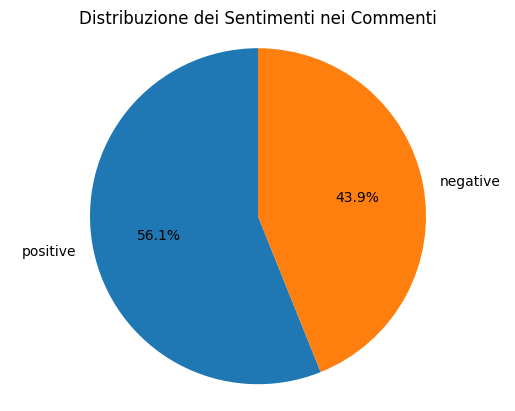

In [ ]:
from feel_it import SentimentClassifier

# Inizializza il classificatore di sentiment
sentiment_classifier = SentimentClassifier()

# Analizza il sentiment dei commenti
sentiments = sentiment_classifier.predict(combined_comments)

# Calcola e visualizza la distribuzione dei sentimenti
from collections import Counter
import matplotlib.pyplot as plt

sentiment_counts = Counter(sentiments)
labels = sentiment_counts.keys()
sizes = sentiment_counts.values()

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribuzione dei Sentimenti nei Commenti')
plt.show()


In [ ]:
# Scrivi i dati nel file JSON
with open('tintoria_sentiments.json', 'w') as json_file:
    json.dump(sentiments, json_file)

In [ ]:
# Carica i dati dal file JSON
with open('tintoria_sentiments.json', 'r') as json_file:
    sentiments = json.load(json_file)

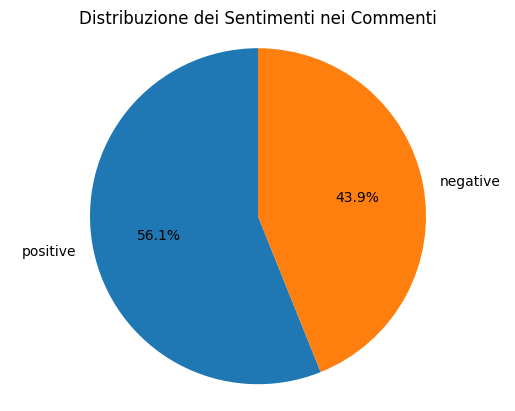

In [ ]:
sentiment_counts = Counter(sentiments)
labels = sentiment_counts.keys()
sizes = sentiment_counts.values()

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribuzione dei Sentimenti nei Commenti')
plt.show()

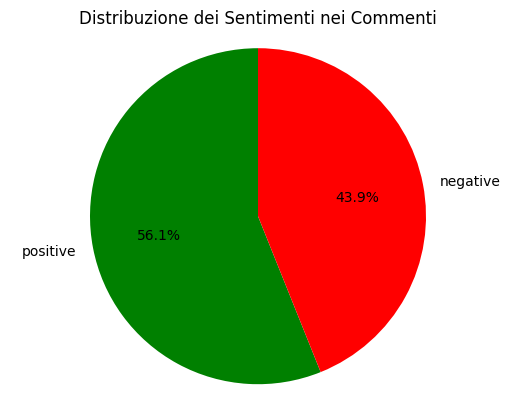

In [ ]:
# Definisci i colori specifici per i sentimenti positivi e negativi
colors = {'positive': 'green', 'negative': 'red'}

# Crea una lista di colori in base all'ordine dei labels
plot_colors = [colors[label] for label in labels]

# Crea il grafico a torta
plt.pie(sizes, labels=labels, colors=plot_colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribuzione dei Sentimenti nei Commenti')
plt.show()

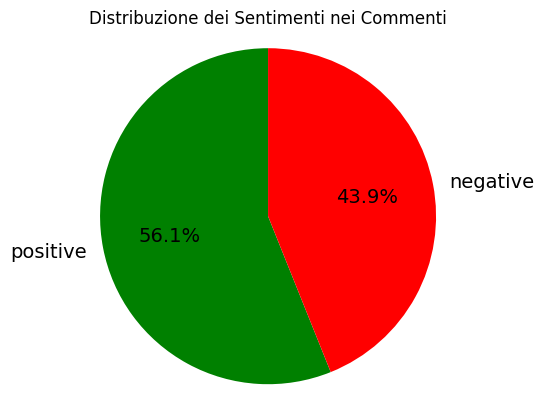

In [ ]:
# Definisci i colori specifici per i sentimenti positivi e negativi
colors = {'positive': 'green', 'negative': 'red'}

# Crea una lista di colori in base all'ordine dei labels
plot_colors = [colors[label] for label in labels]

# Crea il grafico a torta con font size maggiore per le percentuali
plt.pie(sizes, labels=labels, colors=plot_colors, autopct=lambda pct: f'{pct:.1f}%', startangle=90, textprops={'fontsize': 14})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribuzione dei Sentimenti nei Commenti')
plt.show()